### Install/Import libraries
We'll be using numpy, pandas, and xarray for preprocessing, matplotlib for vizualization, tensorflow to construct the model, and the last two are dependencies needed to open the dataset.

In [54]:
! pip install numpy pandas matplotlib xarray tensorflow netcdf4 xarray[io]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from tensorflow import keras
import os

In [3]:
filename = 'c:/Users/sguti/preprocessing/Scorched Earth Data/Mongolia_2D_ERA5_2010_2024.nc'
dataset = xr.open_dataset(filename)
dataset

<xarray.Dataset>
Dimensions:    (time: 5373, step: 24, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 47.8 47.7 47.6 47.5 47.4
  * longitude  (longitude) float64 106.4 106.5 106.6 106.7 106.8
  * step       (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * time       (time) datetime64[ns] 2009-12-31 2010-01-01 ... 2024-03-31
Data variables:
    d2m        (time, step, latitude, longitude) float32 ...
    sp         (time, step, latitude, longitude) float32 ...
    t2m        (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 19 16:26:46 2024: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

### Preprocessing

In [4]:
clean_ds = dataset.dropna(dim="time", how="any")

In [5]:
days = clean_ds.coords['time'].shape[0]

rows = days * 24
hourly_t2m_ds = np.empty(shape=(rows))
hourly_d2m_ds = np.empty(shape=(rows))
hourly_sp_ds = np.empty(shape=(rows))

row = 0
for x in range(days):
	for y in range(24):
		hourly_t2m_ds[row] = clean_ds["t2m"][x, y, 2, 2]
		hourly_d2m_ds[row] = clean_ds["d2m"][x, y, 2, 2]
		hourly_sp_ds[row] = clean_ds["sp"][x, y, 2, 2]

		row += 1

In [6]:
clean_ds.coords["step"] = ["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00","08:00:00","09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00","18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00","23:00:00"]
dateTimeCoords = []
for date in clean_ds.coords["time"].values:
	for time in clean_ds.coords["step"].values:
		dateTime = str(date)[:11] + time
		dateTimeCoords.append(dateTime)

In [7]:
clean_hourly_ds = xr.Dataset(
    data_vars=dict(
        t2m=(["datetime"], hourly_t2m_ds),
        d2m=(["datetime"], hourly_d2m_ds),
		sp=(["datetime"], hourly_sp_ds),
    ),
    coords=dict(
        datetime=("datetime", np.array(dateTimeCoords, dtype='datetime64[h]'))
    ),
    attrs=dict(description="Hourly data from 2010-01-01 to 2024-03-30 at 47.6N 106.6E Ulaanbaatar, Mongolia."),
)

C:\Users\sguti\AppData\Local\Temp\ipykernel_22508\2520399145.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  clean_hourly_ds = xr.Dataset(


In [8]:
clean_hourly_ds["t2m"] = 9/5 * (clean_hourly_ds["t2m"] - 273.15) + 32
clean_hourly_ds["d2m"] = 9/5 * (clean_hourly_ds["d2m"] - 273.15) + 32
clean_hourly_ds["sp"] /= 100

### Feature Engineering

In [9]:
lag_time = 24
lead_time = 1
window = lag_time + lead_time

In [10]:
def make_supervised(dataset, lag_time, lead_time, dataset_size, features=1):
	### make_supervised(): Creates overlapping samples ###

	window = lag_time + lead_time 
	rows = dataset_size - window

	if features == 1:
		inputs = np.empty((rows, lag_time))
	else:
		inputs = np.empty((rows, lag_time, features))

	outputs = np.empty((rows, lead_time))

	for i in range(rows):
		x = dataset.iloc[i:(i+lag_time)]

		if features == 1:
			y = dataset.iloc[i:(i+lead_time)]
			inputs[i, :] = x
			outputs[i, :] = y
		else:
			y = dataset.iloc[i:(i+lead_time)]["t2m"]
			inputs[i, :, :] = x
			outputs[i, :] = y

	return inputs, outputs

In [11]:
clean_hourly_df = clean_hourly_ds.to_dataframe()
clean_hourly_df.head()

,t2m,d2m,sp
datetime,,,
2010-01-01 00:00:00,-10.466069,-15.221062,850.039375
2010-01-01 01:00:00,-8.896535,-13.519115,850.758750
2010-01-01 02:00:00,-4.705443,-11.755672,851.107500
2010-01-01 03:00:00,-1.632595,-10.515013,851.286875
2010-01-01 04:00:00,1.262605,-8.389434,851.213750


### Training, Validation, and Testing Sets

In [12]:
train_df = clean_hourly_df.loc["2010-01-01T00:00:00.000000000":"2020-12-31T23:00:00.000000000"]
valid_df = clean_hourly_df.loc["2021-01-01T00:00:00.000000000":"2023-12-31T23:00:00.000000000"]
test_df = clean_hourly_df.loc["2024-01-01T00:00:00.000000000":"2024-03-31T23:00:00.000000000"]

In [13]:
X_train, y_train = make_supervised(train_df["t2m"], lag_time, lead_time, len(train_df["t2m"]))
X_valid, y_valid = make_supervised(valid_df["t2m"], lag_time, lead_time, len(valid_df["t2m"]))
X_test, y_test = make_supervised(test_df["t2m"], lag_time, lead_time, len(test_df["t2m"]))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(93191, 24)
(93191, 1)
(25391, 24)
(25391, 1)
(2087, 24)
(2087, 1)


In [14]:
X_train_min = X_train.min()
X_train_max = X_train.max()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_valid = (X_valid - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

## Modeling

### Baseline Model

In [15]:
def baseline_model(X_test):
	predictions = []
	for i in range(X_test.shape[0]):
		predictions.append(X_test[i][-1])
	return np.array(predictions)

In [16]:
norm_predictions = baseline_model(X_test)
# Revert to original scale
predictions = (X_train_max - X_train_min) * norm_predictions + X_train_min

mse = 0
n = y_test.shape[0]
for i in range(n):
	mse += np.square((y_test[i] - predictions[i]))
mse /= n
print(f'Mean Square Error: {mse[0]:.3f}')

Mean Square Error: 95.207


### Univariate LSTM Model

An Long Short-Term Mwmory network is commonly used for forecasting. Typically used for natural language processing, but they can also be used for any time-series forecast context. The LSTM is comprised of units that contain an input gate, an output gate, and a forget gate. This structure helps with retaining useful information while discarding useless information over long period of time. The univariate model will serve as a baseline for more complicated LSTM models. It will only take the 2 meter temperature data to predict the future temperature.

TensorFlow has the Keras API that makes it easy to build deep learning models.

In [17]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout

The batch size is the number of training samples before the model is updated. A commonly used batch size is 32, but tests will have to be made to find the optimal batch size.

The LSTM will take the previous 24 hours as input and then return the temperature at the last time step.

In [18]:
batch_size = 32
input_length = lag_time
variables = 1

uni_lstm_model = Sequential()
uni_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
uni_lstm_model.add(LSTM(units=32, activation='relu', return_sequences=False))
uni_lstm_model.add(Dense(1))

The compile_and_fit function will set the loss, optimizer, any metrics, and train the model. The function has an option to interrupt the training early if the model's performance is not improving after a certain amount of epochs.

In [19]:
MAX_EPOCHS = 10

def compile_and_fit(model, X_train, y_train, X_valid, y_valid, patience=5):
  # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
	# 											patience=patience,
	# 											mode='min')

  model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(),
                metrics=[keras.metrics.MeanAbsoluteError()])

  print(model.summary())
  
  history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                      validation_data=(X_valid, y_valid))
                      # callbacks=[early_stopping])
  return history

In [20]:
history = compile_and_fit(uni_lstm_model, X_train, y_train, X_valid, y_valid)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (32, 32)               │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 259.0160 - mean_absolute_error: 9.2246 - val_loss: 1.9482 - val_mean_absolute_error: 1.0351
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.8089 - mean_absolute_error: 1.0174 - val_loss: 0.6900 - val_mean_absolute_error: 0.6207
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.9014 - mean_absolute_error: 0.7254 - val_loss: 0.4826 - val_mean_absolute_error: 0.5406
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.6176 - mean_absolute_error: 0.5983 - val_loss: 1.0429 - val_mean_absolute_error: 0.9408
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.4701 - mean_absolute_error: 0.5167 - val_loss: 0.3757 - val_mean_absolute_error: 0.4800
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.3235 - mean_absolute_error: 0.4239 - val_loss: 0.0908 - val_mean_absolute_error: 0.1975
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.2801 - mea

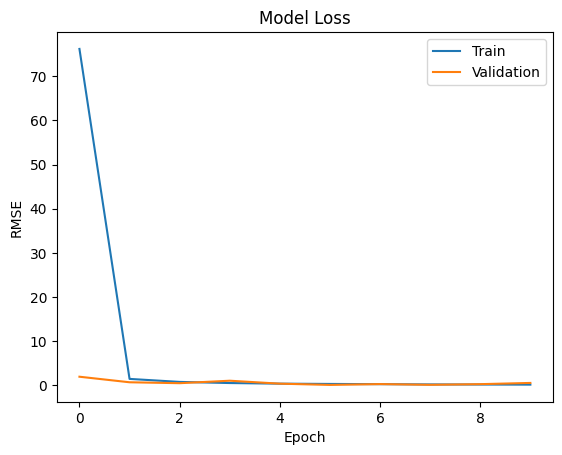

In [21]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [22]:
predictions = uni_lstm_model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


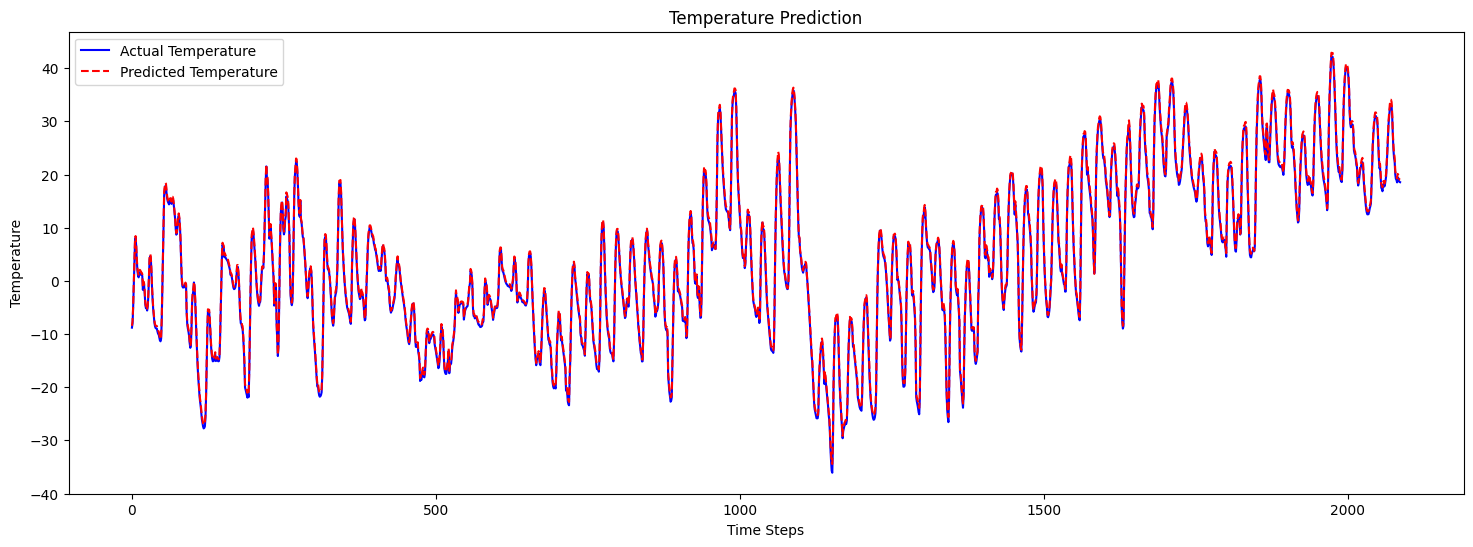

In [23]:
plt.figure(figsize=(18,6))
plt.plot(y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

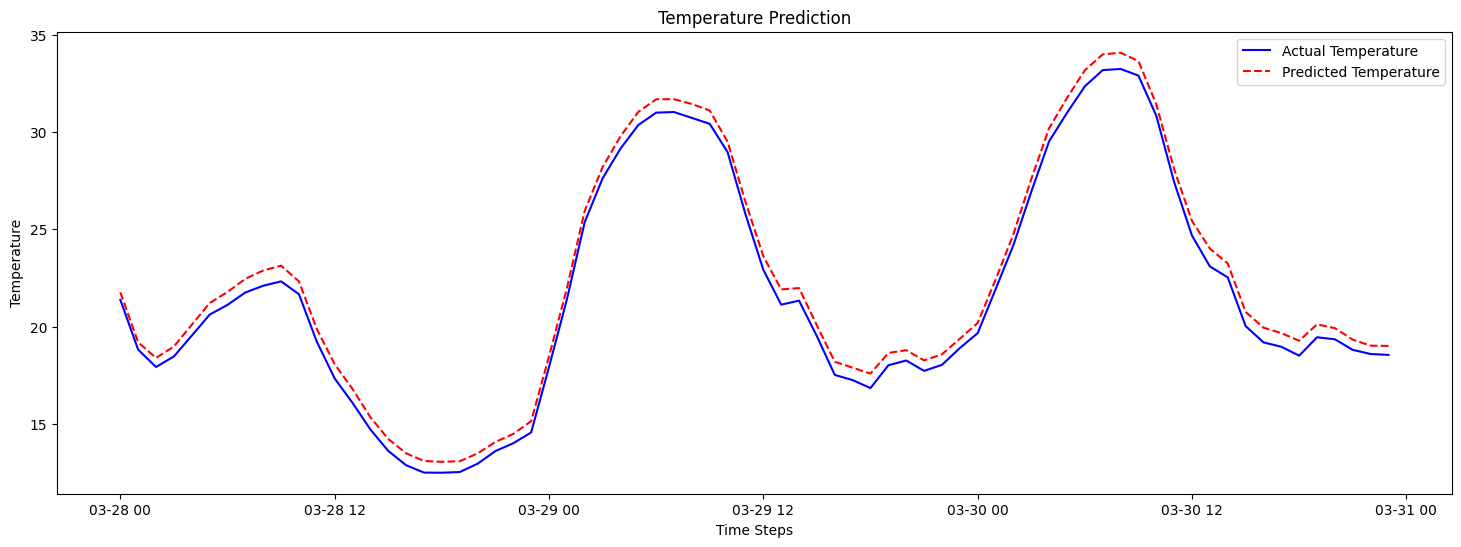

In [24]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Multivariate LSTM Model

In [25]:
multi_train_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2010-01-01T00:00:00':'2020-12-31T23:00:00']
multi_valid_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2021-01-01T00:00:00':'2023-12-31T23:00:00']
multi_test_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2024-01-01T00:00:00':'2024-03-31T23:00:00']

In [26]:
print(multi_train_df.shape)
print(multi_valid_df.shape)
print(multi_test_df.shape)

(93216, 3)
(25416, 3)
(2112, 3)


In [27]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [28]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [29]:
batch_size = 32
input_length = lag_time
variables = 3

multi_lstm_model = Sequential()
multi_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model.add(Dense(1))

In [30]:
multi_history = compile_and_fit(multi_lstm_model, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (32, 32)               │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 284.7877 - mean_absolute_error: 10.9015 - val_loss: 8.8587 - val_mean_absolute_error: 2.2714
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 7.7093 - mean_absolute_error: 2.1662 - val_loss: 2.5105 - val_mean_absolute_error: 1.1851
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.8972 - mean_absolute_error: 1.5404 - val_loss: 3.6162 - val_mean_absolute_error: 1.5904
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2.5382 - mean_absolute_error: 1.2439 - val_loss: 6.0671 - val_mean_absolute_error: 2.1699
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2.1414 - mean_absolute_error: 1.1421 - val_loss: 1.2694 - val_mean_absolute_error: 0.8749
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.7831 - mean_absolute_error: 1.0392 - val_loss: 4.5469 - val_mean_absolute_error: 1.9216
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.6816 - me

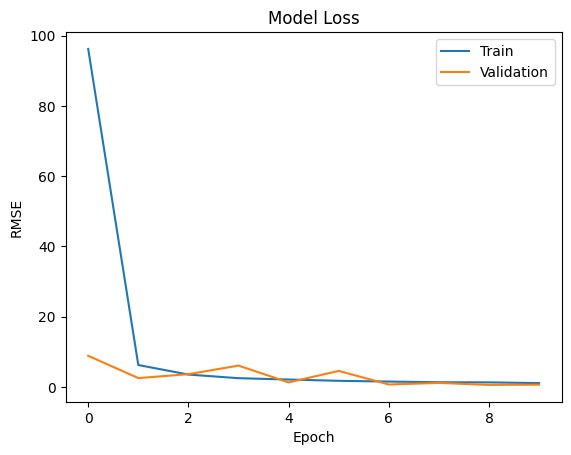

In [31]:
plt.plot(multi_history.history['loss'], label='Train')
plt.plot(multi_history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [32]:
multi_predictions = multi_lstm_model.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


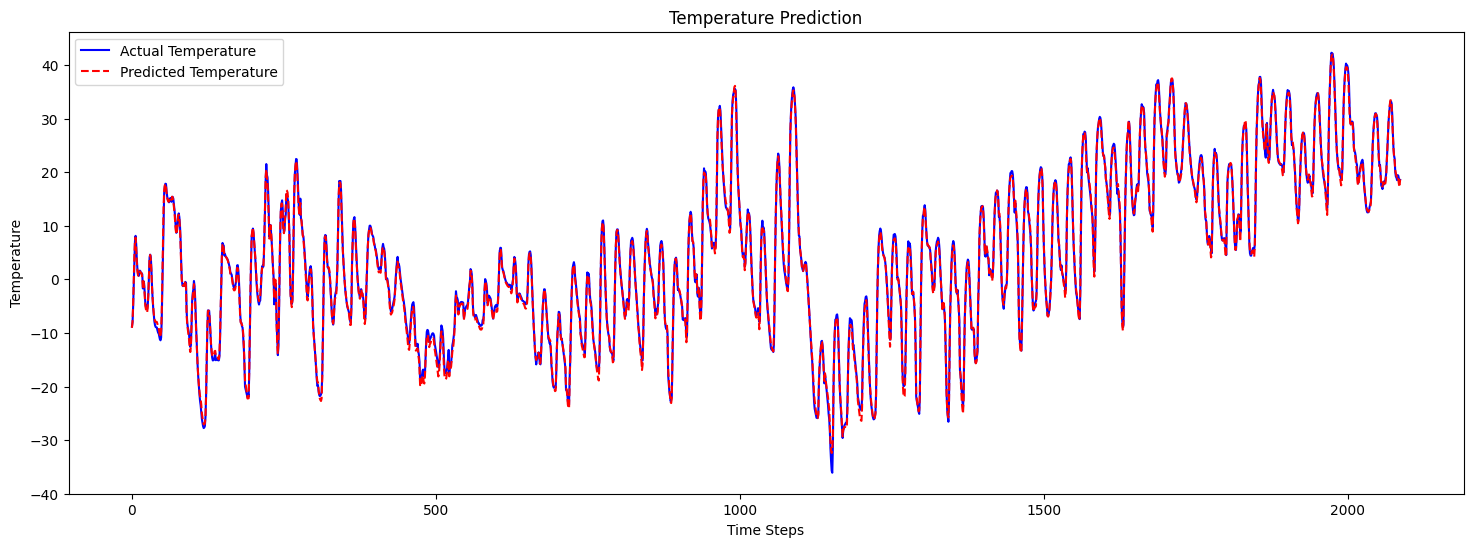

In [33]:
plt.figure(figsize=(18,6))
plt.plot(multi_y_test, color='blue', label='Actual Temperature')
plt.plot(multi_predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

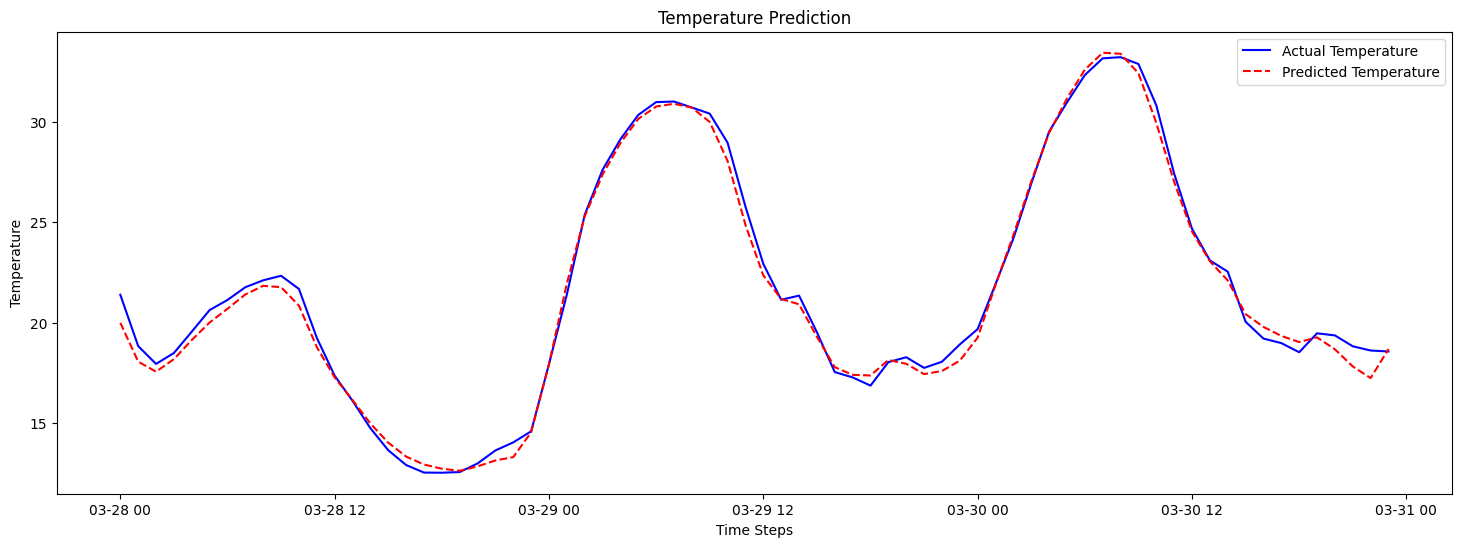

In [34]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], multi_y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Univariate and Multivariate Model Comparison

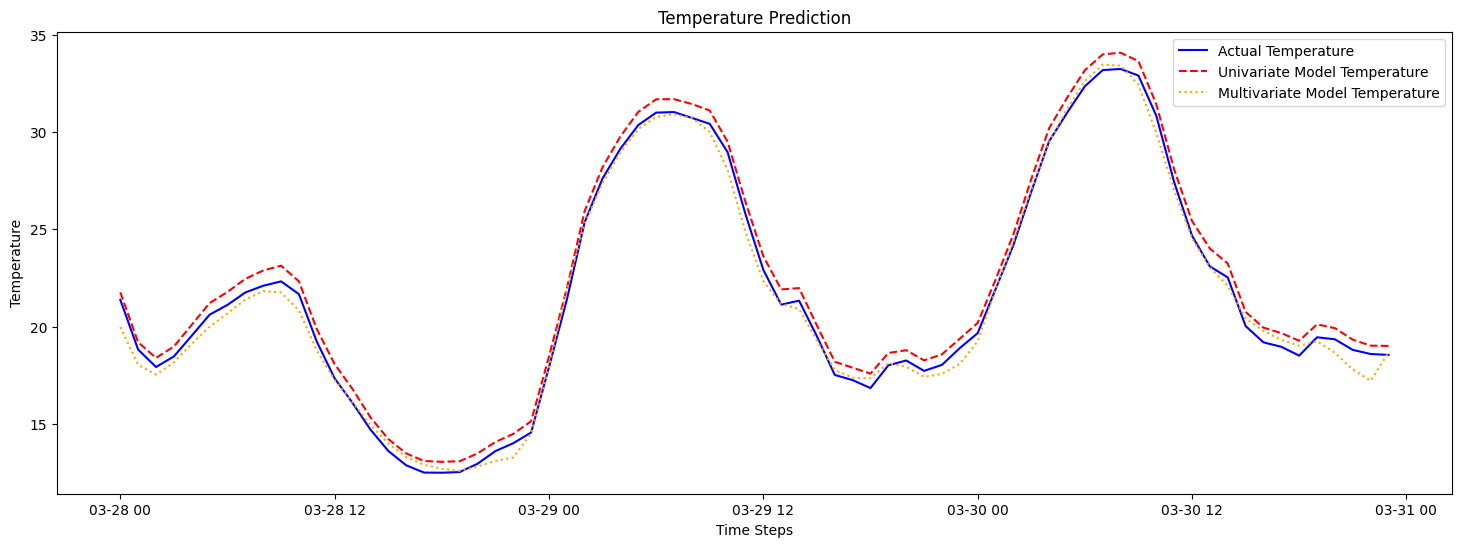

In [35]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Univariate Model Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='orange', linestyle='dotted', label='Multivariate Model Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [36]:
print("Univariate Loss", history.history['loss'][-1])
print("Univariate Validation Loss", history.history['val_loss'][-1])
print("Multivariate Loss", multi_history.history['loss'][-1])
print("Multivariate Validation Loss", multi_history.history['val_loss'][-1])

Univariate Loss 0.15751837193965912
Univariate Validation Loss 0.5415008068084717
Multivariate Loss 1.0755324363708496
Multivariate Validation Loss 0.6365273594856262


While the multivariate LSTM model's training loss is lower than the univariate, it performed better on the validation set. Yet, the multivariate LSTM model is marginally better. To further decrease the loss, it would be more productive to do feature engineering and feature selection rather than adding more complexity to the model.

In [37]:
lag_time = 24
lead_time = 2
window = lag_time + lead_time

In [38]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [39]:
print(multi_X_train.shape)
print(multi_y_train.shape)

(93190, 24, 3)
(93190, 2)


In [40]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [41]:
multi_lstm_model_2 = Sequential()
multi_lstm_model_2.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_2.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_2.add(Dense(lead_time))

In [42]:
multi_step_history_2 = compile_and_fit(multi_lstm_model_2, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (32, 32)               │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,674 (18.26 KB)

 Trainable params: 4,674 (18.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 238.5860 - mean_absolute_error: 9.3673 - val_loss: 4.7847 - val_mean_absolute_error: 1.7774
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.9345 - mean_absolute_error: 1.5222 - val_loss: 3.9024 - val_mean_absolute_error: 1.5676
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3.1946 - mean_absolute_error: 1.3778 - val_loss: 2.0650 - val_mean_absolute_error: 1.0680
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2.8020 - mean_absolute_error: 1.2864 - val_loss: 1.8276 - val_mean_absolute_error: 1.0122
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2.5450 - mean_absolute_error: 1.2280 - val_loss: 1.5666 - val_mean_absolute_error: 0.9440
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 1.9926 - mean_absolute_error: 1.0894 - val_loss: 4.2915 - val_mean_absolute_error: 1.7789
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.6800 - mea

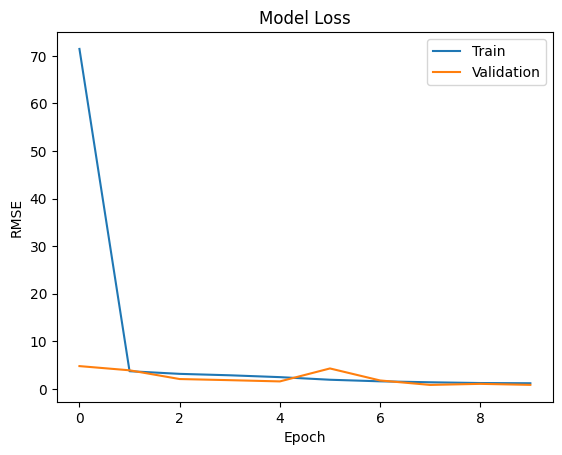

In [43]:
plt.plot(multi_step_history_2.history['loss'], label='Train')
plt.plot(multi_step_history_2.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [44]:
multi_predictions_2 = multi_lstm_model_2.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [45]:
lag_time = 24
lead_time = 6
window = lag_time + lead_time

In [46]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [47]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [48]:
multi_lstm_model_24hr_6lead = Sequential()
multi_lstm_model_24hr_6lead.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_24hr_6lead.add(LSTM(units=64, activation='relu', return_sequences=True))
multi_lstm_model_24hr_6lead.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_24hr_6lead.add(Dense(lead_time))

In [49]:
multi_step_history_24hr_6lead = compile_and_fit(multi_lstm_model_24hr_6lead, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (32, 24, 64)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (32, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,022 (117.27 KB)

 Trainable params: 30,022 (117.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - loss: 233.1032 - mean_absolute_error: 9.2317 - val_loss: 15.8620 - val_mean_absolute_error: 3.0212
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 16.0628 - mean_absolute_error: 3.0224 - val_loss: 16.0322 - val_mean_absolute_error: 3.0854
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 14.7038 - mean_absolute_error: 2.8431 - val_loss: 11.5543 - val_mean_absolute_error: 2.7926
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 5.3971 - mean_absolute_error: 1.7604 - val_loss: 2.1985 - val_mean_absolute_error: 1.1132
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 2.6876 - mean_absolute_error: 1.2529 - val_loss: 2.8311 - val_mean_absolute_error: 1.3489
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 2.1268 - mean_absolute_error: 1.1154 - val_loss: 3.0209 - val_mean_absolute_error: 1.3902
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 

In [50]:
multi_predictions_24hr_6lead = multi_lstm_model_24hr_6lead.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


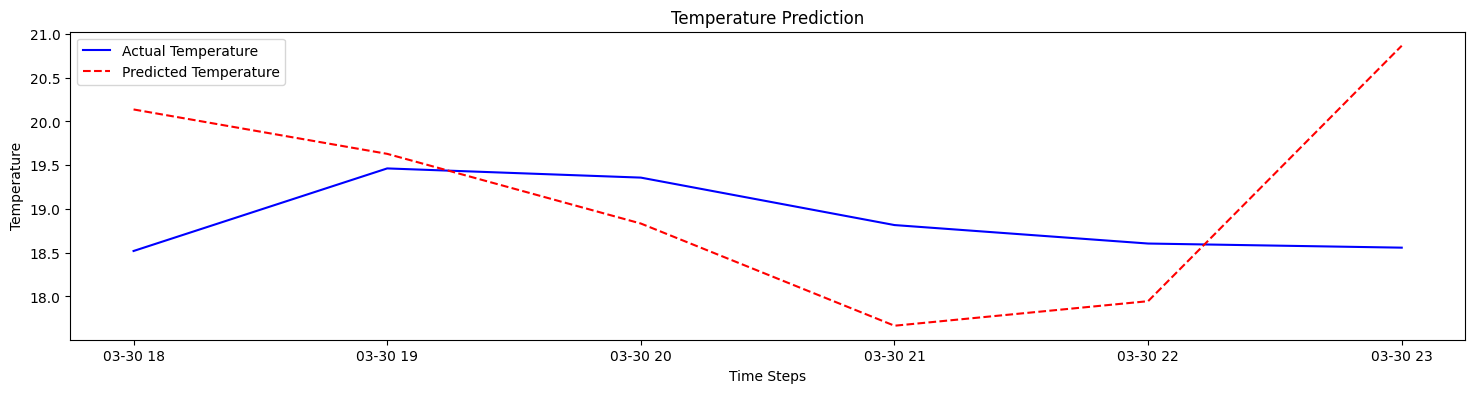

In [51]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-6:], multi_y_test[-1], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-6:], multi_predictions_24hr_6lead[-1], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

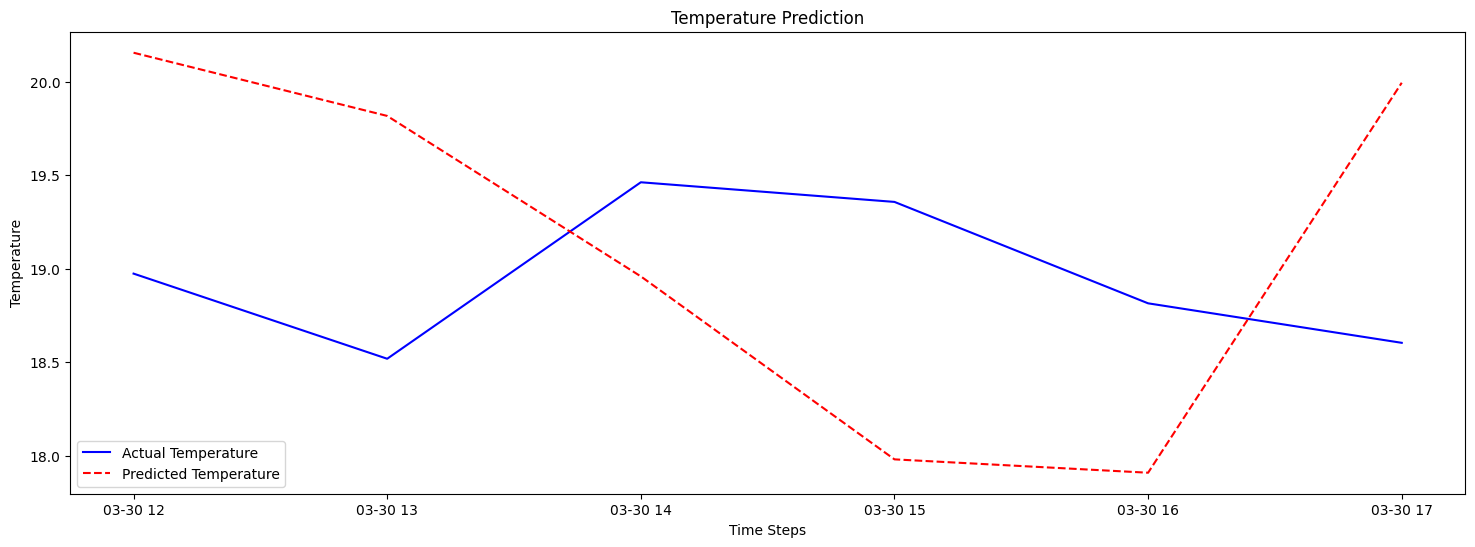

In [52]:
plt.figure(figsize=(18,6))

plt.plot(test_df.index[-12:-6], multi_y_test[-2], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-12:-6], multi_predictions_24hr_6lead[-2], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [53]:
lag_time = 48
lead_time = 6
window = lag_time + lead_time

In [54]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [55]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [74]:
multi_lstm_model_48hr_6lead = Sequential()
multi_lstm_model_48hr_6lead.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_48hr_6lead.add(LSTM(units=64, activation='relu', return_sequences=True))
multi_lstm_model_48hr_6lead.add(LSTM(units=32, activation='relu', return_sequences=False))
multi_lstm_model_48hr_6lead.add(Dense(lead_time))

In [75]:
multi_step_history_48hr_6lead = compile_and_fit(multi_lstm_model_48hr_6lead, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (32, 24, 64)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (32, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,022 (117.27 KB)

 Trainable params: 30,022 (117.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 90s 30ms/step - loss: 466.0687 - mean_absolute_error: 13.7395 - val_loss: 20.7506 - val_mean_absolute_error: 3.5376
Epoch 2/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - loss: 19.7630 - mean_absolute_error: 3.4385 - val_loss: 13.3308 - val_mean_absolute_error: 2.7286
Epoch 3/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 13.2580 - mean_absolute_error: 2.6565 - val_loss: 5.9428 - val_mean_absolute_error: 1.7860
Epoch 4/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - loss: 5.3094 - mean_absolute_error: 1.7186 - val_loss: 3.3042 - val_mean_absolute_error: 1.3652
Epoch 5/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 3.4501 - mean_absolute_error: 1.4062 - val_loss: 1.9621 - val_mean_absolute_error: 1.0345
Epoch 6/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 2.5161 - mean_absolute_error: 1.2110 - val_loss: 2.0918 - val_mean_absolute_error: 1.0871
Epoch 7/10
2912/2912 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - loss: 

In [76]:
multi_predictions_48hr_6lead = multi_lstm_model_48hr_6lead.predict(multi_X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


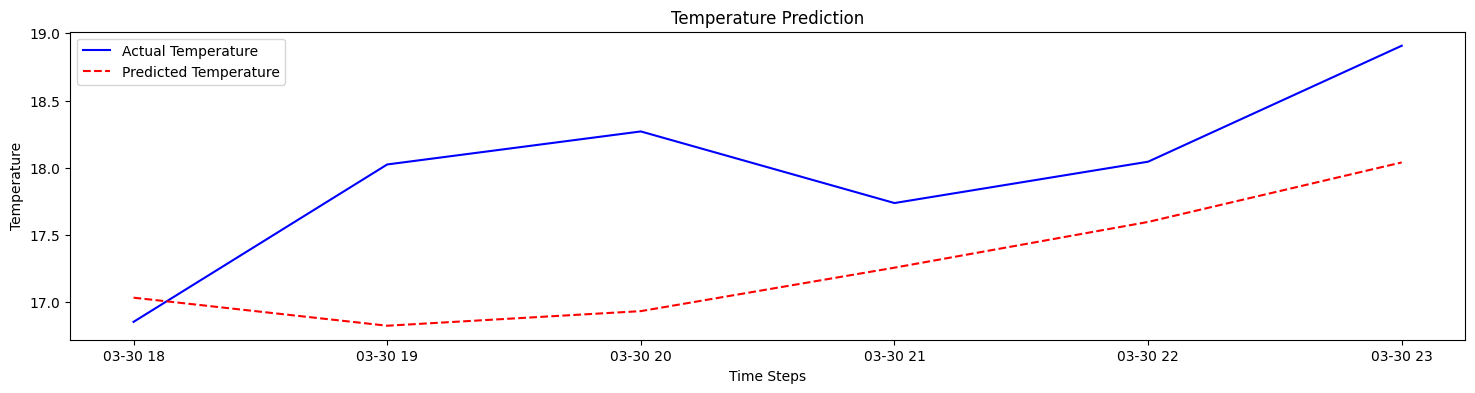

In [77]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-6:], multi_y_test[-1], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-6:], multi_predictions_48hr_6lead[-1], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

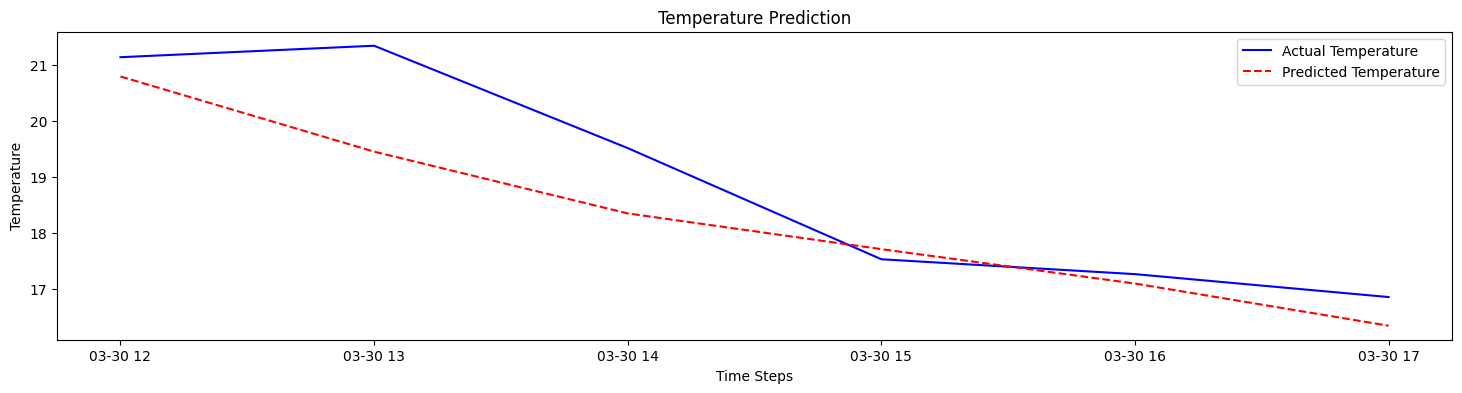

In [78]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-12:-6], multi_y_test[-6], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-12:-6], multi_predictions_48hr_6lead[-6], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

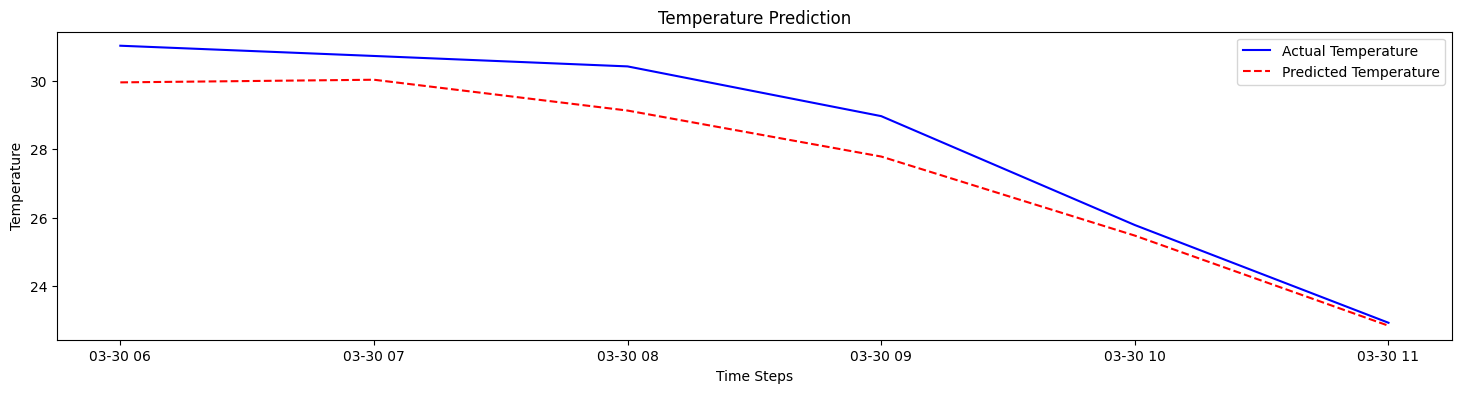

In [79]:
plt.figure(figsize=(18,4))

plt.plot(test_df.index[-18:-12], multi_y_test[-12], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-18:-12], multi_predictions_48hr_6lead[-12], color='red', linestyle='--', label='Predicted Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [99]:
test_scores = multi_lstm_model_48hr_6lead.evaluate(x=multi_X_test, y=multi_y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5405 - mean_absolute_error: 1.0298


In [100]:
multi_lstm_model_48hr_6lead.save("../../server/models/mongolia_lstm.keras")

In [101]:
new_model = keras.models.load_model("../../server/models/mongolia_lstm.keras")
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (32, 24, 64)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (32, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,068 (351.83 KB)

 Trainable params: 30,022 (117.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,046 (234.56 KB)

In [119]:
mse, mae = new_model.evaluate(multi_X_test, multi_y_test)
new_model_predictions = new_model.predict(multi_X_test)
metrics = new_model.get_metrics_result()
print(metrics)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5405 - mean_absolute_error: 1.0298
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
{'loss': 1.5790373086929321, 'mean_absolute_error': 1.0382800102233887}
